# Estimator Benchmarks

Notebook for benchmarking known IV estimators against different data generating processes.

Current roster:
- Split-sample IV **TODO**
- 2SLS
- Jackknife IV **TODO**
- LIML 
- Mostly harmless ML
- DeepIV **TODO**
- DoubleML **TODO**
- ML'd IV **TODO** Singh et al. 2023

# Imports

In [11]:
from glob import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm

In [12]:
from src.model import PoolingMLP
from src.data.lennon_iv_generator import LennonIVGenerator, generate_cov_matrix
from src.viz.plotting import kde_ridgeplot

# Load benchmarking results

In [13]:
result_dir = "../results/benchmark_lennon100/"

models = [
    "TSLS",
    "LIML",
    "OLS",
    "MHML"
]

benchmark_results = {
    model: pd.read_parquet(os.path.join(result_dir, f"{model}_results.parquet")) for model in models
}

In [14]:
MODEL_CHKPT = "/home/tliu/learning-ivs/workdir/pool_mlp_lennon_bs256_lr0.004_eps100_hidden256_depth4/ckpts/exp_name=pool_mlp_lennon_bs256_lr0.004_eps100_hidden256_depth4-val_loss=0.0070.ckpt"
data_dir = "/home/tliu/learning-ivs/datasets/linear/lennon100/test"

model = PoolingMLP.load_from_checkpoint(MODEL_CHKPT)
model.eval();

/home/tliu/learning-ivs/src/model/pooling_mlp.py:109: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight)


In [15]:
pooled_mlp_preds = []

for file_name in tqdm(glob(f"{data_dir}/*.parquet")):
    df = pd.read_parquet(file_name)
    # pooled MLP
    data = torch.tensor(df.to_numpy(), dtype=torch.float32)
    #print(data.shape)
    # create a batch dimension
    data = data.unsqueeze(0)
    pooled_mlp_preds.append(model(data).squeeze().item())

0it [00:00, ?it/s]


In [16]:
benchmark_results["TSLS"].head()

,tau,se,ground_truth,idx
0,1.398952,0.084520,1.0,0
1,1.486148,0.080369,1.0,1
2,1.463310,0.076734,1.0,2
3,1.403686,0.080071,1.0,3
4,1.408438,0.068298,1.0,4


In [17]:
result_df = pd.DataFrame()
for k, df in benchmark_results.items():
    df["model"] = k
    result_df = pd.concat([result_df, df[['tau', 'model']]])


In [18]:
pooled_df = pd.DataFrame(pooled_mlp_preds, columns=["tau"])
pooled_df["model"] = "Pooled MLP"
result_df = pd.concat([result_df, pooled_df])

In [19]:
result_df.shape

(4000, 2)

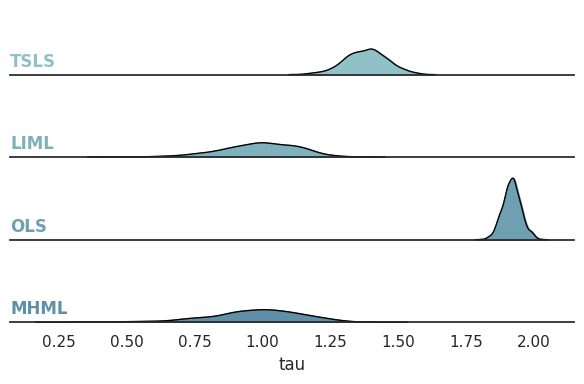

In [20]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
kde_ridgeplot(result_df, 'model', 'tau', pal, figsize=(6, 4))

# Lennon et al. 2022 Replication

In [21]:
n_samples = 1000
mu2 = 180
n_instruments = 100
iv_gen = LennonIVGenerator(
            tau_range=[1,1],
            max_vars=n_instruments,
            n_instruments=n_instruments,
            #instrument_covariance=torch.Tensor(generate_cov_matrix(n_instruments)), 
            instrument_cov_base=0.5,
            instrument_strength=mu2/n_samples,
        )

data = iv_gen.batch(tau=1, batch_size=n_samples).detach().numpy()

In [22]:
data.shape

(1000, 102)

In [23]:
data[:, :-2].shape

(1000, 100)

<Axes: >

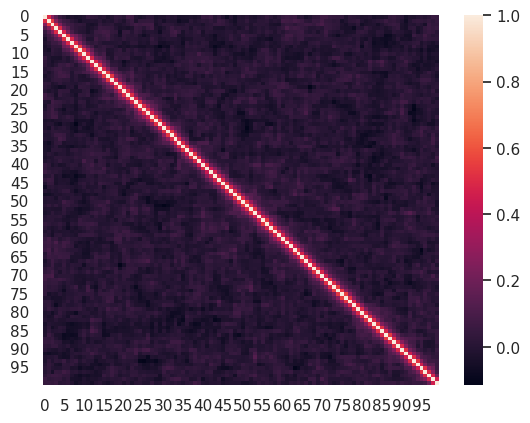

In [24]:
sns.heatmap(np.corrcoef(data[:, 2:].T))

In [25]:
# Initialize the FacetGrid object
#plt.axvline(x=1, ls='--', color='black')
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
kde_ridgeplot(result_df_long, 'method', 'estimate', pal, figsize=(6, 4))
#plt.xlim(0.5, 2)

NameError: name 'result_df_long' is not defined

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("/home/tliu/learning-ivs/tmp_lennon100/train/uid=0-treatment_effect=-1.1086778243435313-n_samples=1000.parquet")

In [ ]:
df.dtypes

T      float32
Y      float32
Z0     float32
Z1     float32
Z2     float32
        ...   
Z95    float32
Z96    float32
Z97    float32
Z98    float32
Z99    float32
Length: 102, dtype: object